# Avaliação do Modelo WDO
Avaliação completa do modelo com backtest, métricas de performance e análise de risco.

In [2]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path(os.path.dirname(os.getcwd()))
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# Configura visualizações
plt.style.use('default')
pd.set_option('display.max_columns', None)

## 1. Carrega Dados e Modelo

In [3]:
# Carrega dados
from src.data.loaders.market_data_loader import MarketDataLoader

db_path = PROJECT_ROOT / 'src' / 'data' / 'database' / 'candles.db'
loader = MarketDataLoader(str(db_path))
data = loader.load_data()

print(f'Período dos dados: {data.index.min()} até {data.index.max()}')

Período dos dados: 2024-03-22 12:57:00 até 2024-11-29 18:29:00


## 2. Backtest

In [4]:
from src.ml.features.feature_engineering import FeatureEngineering
from src.agents.market_agent import RiskManagementAgent, MarketRegimeAgent
from src.agents.agent_coordinator import AgentCoordinator

# Prepara features
engineer = FeatureEngineering()
features = engineer.create_technical_features(data)
features = engineer.create_temporal_features(features)

# Configura agentes
risk_agent = RiskManagementAgent(max_drawdown=-0.05)
regime_agent = MarketRegimeAgent(window_size=20)

coordinator = AgentCoordinator([risk_agent, regime_agent])

# Prepara dados para backtest
test_size = int(len(features) * 0.3)  # 30% para teste
train_data = features[:-test_size]
test_data = features[-test_size:]

print(f'Dados de treino: {len(train_data)} registros')
print(f'Dados de teste: {len(test_data)} registros')

Dados de treino: 66177 registros
Dados de teste: 28361 registros


Resultados da Simulação:
VaR (95%): -3.44%
CVaR (95%): -5.31%


c:\Users\rlcp0\AI Office\aioffice_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


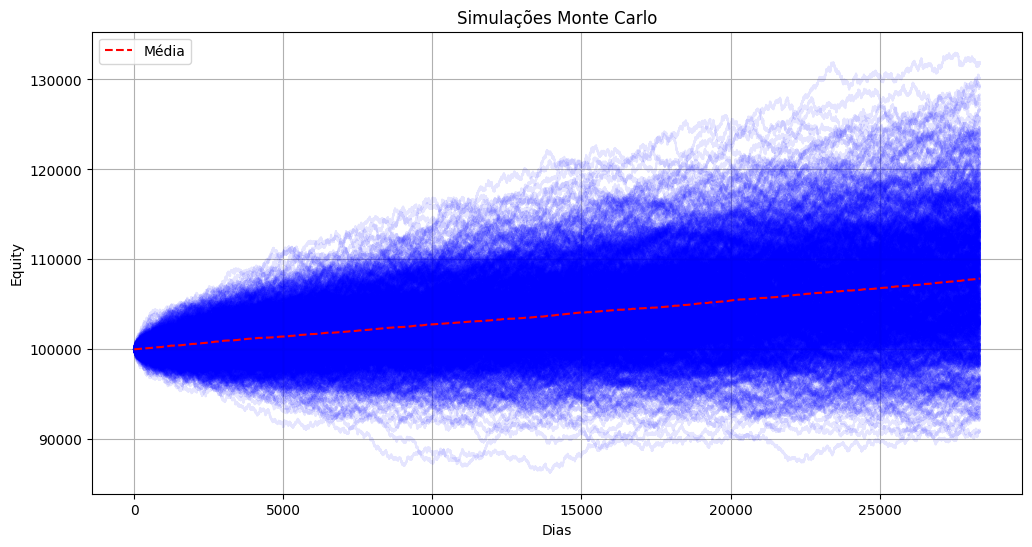

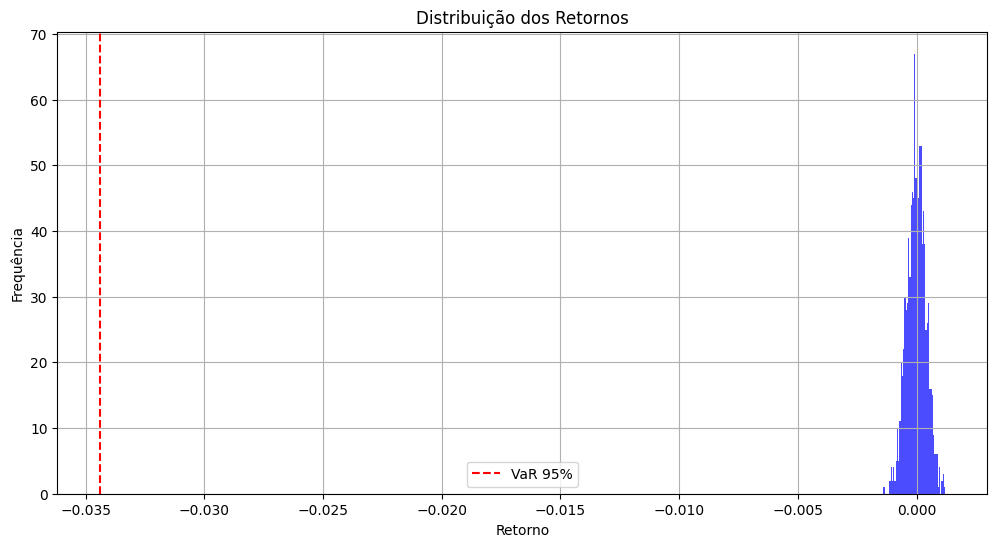

In [5]:
from src.backtest.monte_carlo import MonteCarloSimulator

# Executa simulações
simulator = MonteCarloSimulator(n_simulations=1000)

# Simula com dados de teste
returns = test_data['returns'].dropna()
simulation = simulator.simulate_returns(
    historical_returns=returns,
    initial_capital=100000
)

print('Resultados da Simulação:')
print(f'VaR (95%): {simulation.var:.2%}')
print(f'CVaR (95%): {simulation.cvar:.2%}')

# Plota resultados
simulator.plot_simulations(simulation)

## 3. Métricas de Performance

In [7]:
from src.reporting.summary.performance_summary import PerformanceSummary

# Converte resultados da simulação para formato de trades
trades = []
equity_curve = simulation.equity_curves[0]  # Usando primeira simulação como exemplo
returns = np.diff(equity_curve) / equity_curve[:-1]

for i in range(len(returns)):
    trade = {
        'entry_date': test_data.index[i],
        'exit_date': test_data.index[i+1],
        'pnl': (equity_curve[i+1] - equity_curve[i]),
        'return': returns[i]
    }
    trades.append(trade)

# Calcula métricas
summary = PerformanceSummary()
metrics = summary.calculate_metrics(trades=trades)

print('\nMétricas de Performance:')
for metric, value in metrics.items():
    if isinstance(value, float):
        print(f'{metric}: {value:.2%}')
    else:
        print(f'{metric}: {value}')


Métricas de Performance:
total_trades: 28360
winning_trades: 14321
losing_trades: 14039
win_rate: 50.50%
total_pnl: 658791.33%
return: 6.59%
max_drawdown: 5.19%
profit_factor: 101.46%
avg_win: 3191.88%
avg_loss: 3209.07%
sharpe_ratio: 186.42%


## 4. Análise de Risco

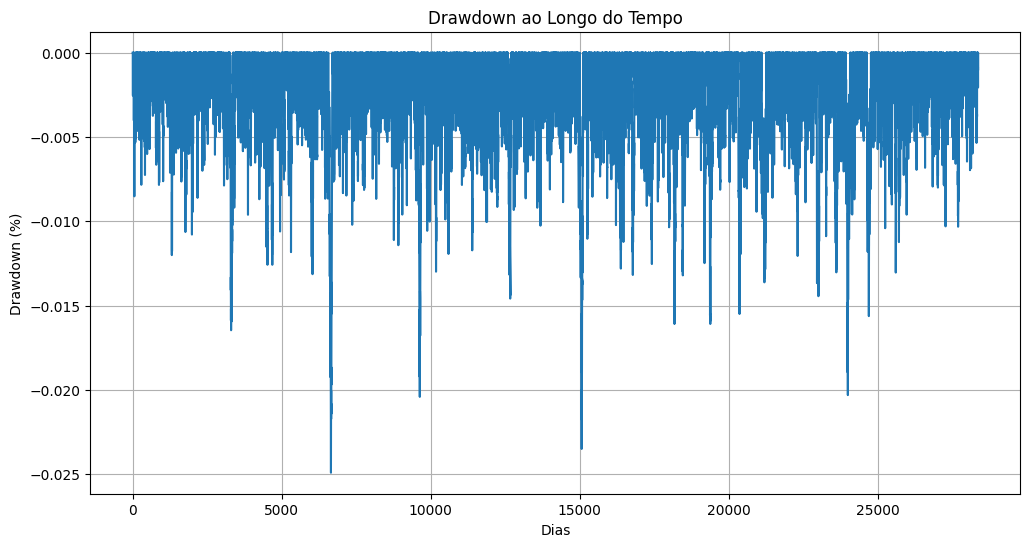

Máximo Drawdown: -0.02%


In [8]:
# Calcula drawdown
equity = simulation.equity_curves.mean(axis=0)
running_max = np.maximum.accumulate(equity)
drawdown = (equity - running_max) / running_max * 100

plt.figure(figsize=(12, 6))
plt.plot(drawdown)
plt.title('Drawdown ao Longo do Tempo')
plt.xlabel('Dias')
plt.ylabel('Drawdown (%)')
plt.grid(True)
plt.show()

print(f'Máximo Drawdown: {drawdown.min():.2f}%')

## 5. Análise dos Agentes

In [10]:
# Coleta insights dos agentes
insights = coordinator.get_agent_insights()

print('Insights dos Agentes:')
for agent_name, agent_insights in insights.items():
    print(f'{agent_name}:')
    for metric, value in agent_insights.items():
        print(f'- {metric}: {value}')

Insights dos Agentes:
RiskManagementAgent:
- max_drawdown: -0.05
- max_position_size: 3
- current_risk_level: normal
MarketRegimeAgent:
- current_regime: None
- regime_transitions: 0
- volatility_trend: undefined
